# Potential Talent






## Background

#### As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

#### The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

#### We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

#### Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

## Goals
#### - Predict how fit the candidate is based on their available information (variable fit)
#### - Rank candidates based on a fitness score.
#### - Re-rank candidates when a candidate is starred.

## Setup

In [1]:
!pip install numpy==1.25.2 # Downgrade NumPy to 1.25.2
!pip install gensim
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=41a626dfd5e6dc119e95d91a208a79f2008fd9ec3a2ae84206041ce09f9fc64e
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import random
import requests
import sys
import regex as re
import plotly.express as px
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from sklearn.feature_selection import RFE
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
warnings.filterwarnings('ignore', category=UserWarning)

### Data extraction

In [3]:
### Upload file before running this step
file_path = '/content/Extended Dataset for Potential Talents.xlsx'

df = pd.read_excel(file_path)
df


,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100
...,...,...,...,...
1280,1281,GenAINLPCVML Senior AI Engineer Data Scientist...,India,0
1281,1282,Data Scientist and Analyst Driving Business In...,Kenya,0
1282,1283,Software Engineer WriterSpace Science Enthusiast,Ethiopia,0
1283,1284,Master Trainer of Big Data Analytics Data Scie...,Jordan,0


## Exploratory Data Analysis

### Data Validation

In [4]:
# check for missing values
df.isnull().sum()

,0
id,0
title,4
location,0
screening_score,0


In [5]:
# check data types
df.dtypes

,0
id,int64
title,object
location,object
screening_score,int64


In [6]:
print(df.describe())
print(df.describe(include=['object']))

                id  screening_score
count  1285.000000      1285.000000
mean    643.000000        62.613230
std     371.091857        32.177719
min       1.000000         0.000000
25%     322.000000        30.000000
50%     643.000000        80.000000
75%     964.000000        90.000000
max    1285.000000       100.000000
               title       location
count           1281           1285
unique          1206             40
top     data analyst  United States
freq              19           1127


In [7]:
for col in df.columns:
  print(f"Unique values for column '{col}':")
  print(df[col].unique())
  print("-" * 20)


Unique values for column 'id':
[   1    2    3 ... 1283 1284 1285]
--------------------
Unique values for column 'title':
['innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.'
 'ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025'
 'computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs'
 ... 'Software Engineer WriterSpace Science Enthusiast'
 'Master Trainer of Big Data Analytics Data Scientist'
 'Digital Marketing Strategist Growth Performance Marketing SEO PPC Social Media Expert']
--------------------
Unique values for column 'location':
['United States' 'United Kingdom' 'Brazil' 'Austria'
 'United Arab Emirates' 'China' 'Germany' 'Pakistan' 'India' 'Egypt'
 'Ethiopia' 'Kenya' 'Indonesia' 'Philippines' 

### Data Wrangling

In [8]:
# show rows with null values
df[df.isnull().any(axis=1)]

,id,title,location,screening_score
14,15,NaN,United States,100
193,194,NaN,Austria,50
248,249,NaN,United States,30
587,588,NaN,United States,85


In [9]:
print('Before removing nulls: ', len(df))
# remove null rows as missing title info will be of no value for analysis.
df = df.dropna()
print('After removing nulls: ', len(df))
df

Before removing nulls:  1285
After removing nulls:  1281


,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100
...,...,...,...,...
1280,1281,GenAINLPCVML Senior AI Engineer Data Scientist...,India,0
1281,1282,Data Scientist and Analyst Driving Business In...,Kenya,0
1282,1283,Software Engineer WriterSpace Science Enthusiast,Ethiopia,0
1283,1284,Master Trainer of Big Data Analytics Data Scie...,Jordan,0


In [10]:
# check for missing values
df.isnull().sum()

,0
id,0
title,0
location,0
screening_score,0


In [11]:
print('Total rows: ', len(df))
# Assuming df is your DataFrame and 'title' is the column name
def check_title(title):
    if pd.isna(title):
        return True  # Consider missing values as invalid
    match = re.search(r"^[^a-zA-Z0-9]", str(title))
    return bool(match)

df['invalid_title'] = df['title'].apply(check_title)

# Display rows with invalid titles

print('# of rows with non-alpha characters at beginning of title', len(df[df['invalid_title']]))
df[df['invalid_title']]

Total rows:  1281
# of rows with non-alpha characters at beginning of title 17


<ipython-input-11-d53f39042bbe>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['invalid_title'] = df['title'].apply(check_title)


,id,title,location,screening_score,invalid_title
131,132,--,United States,80,True
172,173,--,United States,80,True
175,176,.,United States,75,True
384,385,--,United States,100,True
431,432,--,United States,95,True
498,499,-data scientist analytics transforming busines...,United States,95,True
574,575,--,United States,90,True
711,712,--,United States,80,True
714,715,--,United States,80,True
818,819,--,United States,80,True


In [12]:
### function to remove non-alphanumeric characters at beggining of title.
def clean_title(text):
  # Regular expression to match '-' or '.' not preceded by a letter
  pattern = r"(?<!\w)[-.]"
  return re.sub(pattern, "", text)


# Example usage with your DataFrame
df['title'] = df['title'].apply(clean_title)
df = df[df['title'].astype(str).str.strip() != '']
print('Total rows after cleaning: ', len(df))

Total rows after cleaning:  1265


<ipython-input-12-f3160dd8248e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].apply(clean_title)


In [13]:
# recheck for invalid titles
df['invalid_title'] = df['title'].apply(check_title)

# Display rows with invalid titles

print('# of rows with non-alpha characters at beginning of title', len(df[df['invalid_title']]))
df[df['invalid_title']]


# of rows with non-alpha characters at beginning of title 0


<ipython-input-13-ef63a13cbce0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['invalid_title'] = df['title'].apply(check_title)


,id,title,location,screening_score,invalid_title


In [14]:
# remove column invalid_title

df = df.drop('invalid_title', axis=1)
df

,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100
...,...,...,...,...
1280,1281,GenAINLPCVML Senior AI Engineer Data Scientist...,India,0
1281,1282,Data Scientist and Analyst Driving Business In...,Kenya,0
1282,1283,Software Engineer WriterSpace Science Enthusiast,Ethiopia,0
1283,1284,Master Trainer of Big Data Analytics Data Scie...,Jordan,0


In [15]:
# Convert 'title' column to lowercase
df['title'] = df['title'].str.lower()
df


,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100
...,...,...,...,...
1280,1281,genainlpcvml senior ai engineer data scientist...,India,0
1281,1282,data scientist and analyst driving business in...,Kenya,0
1282,1283,software engineer writerspace science enthusiast,Ethiopia,0
1283,1284,master trainer of big data analytics data scie...,Jordan,0


### Data Visualization

#### Word Cloud

In [16]:
# Join titles
text = df['title'].str.cat(sep=' ')

text

'innovative and driven professional seeking a role in data analyticsdata science in the information technology industry. ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025 computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-ericsson graduate research assistant at uab masters in data science student at uab ex jio student at kennesaw state university data analyst business analyst python snowflake sql machine learning power bi tableau equipped with analytics driven by insights and passionate about impactful solutions. graduate research aide student at arizona state university data sci

In [18]:
# set stop words
stopwords = set(STOPWORDS)

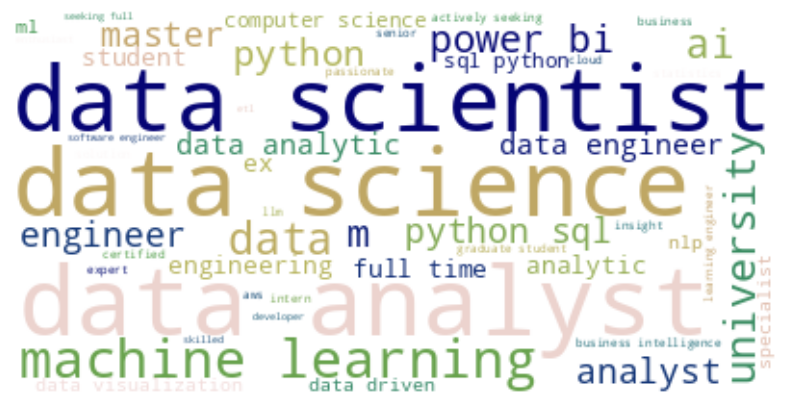

In [19]:
# size of word cloud
plt.figure(figsize=(10, 5))

# make wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color='white', colormap='gist_earth').generate(text)

# plot wprd cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

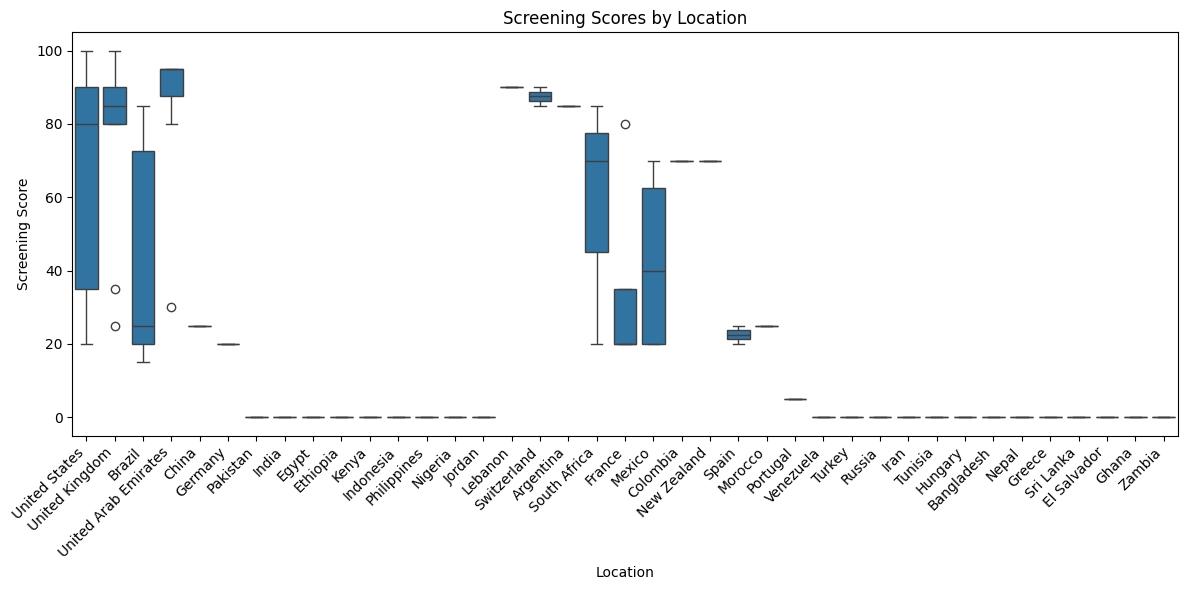

In [20]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='screening_score', data=df)
plt.title('Screening Scores by Location')
plt.xlabel('Location')
plt.ylabel('Screening Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


#### Chloropeth Maps

In [21]:
import plotly.express as px

# Group by location and count the number of IDs
location_id_counts = df.groupby('location')['id'].count().reset_index()
location_id_counts.rename(columns={'id': 'id_count'}, inplace=True)

# Find the maximum ID count to adjust the color scale
max_id_count = location_id_counts['id_count'].max()

# Apply a logarithmic transformation to reduce the impact of the highest country
location_id_counts['log_id_count'] = np.log1p(location_id_counts['id_count'])

# Create the choropleth plot using plotly express
fig = px.choropleth(location_id_counts,
                    locations='location',  # Assuming 'location' column contains country codes or names
                    locationmode='country names',  # Set locationmode accordingly
                    color='log_id_count',  # Use log-transformed ID count for coloring
                    hover_name='location',  # Hover information
                    hover_data={'id_count': True}, # Show both log and raw counts on hover
                    color_continuous_scale='Viridis',  # Customize the color scale
                    title='ID Count by Country (Logarithmic Scale)',
                    range_color=(location_id_counts['log_id_count'].min(), location_id_counts['log_id_count'].max())) # Set range for consistent color scale
fig.show()


In [22]:
# create a chloropeth plot of average screening score by country

import plotly.express as px

# Assuming 'df' is your DataFrame and it contains 'location' and 'screening_score' columns
# Group by location and calculate the average screening score
location_score_avg = df.groupby('location')['screening_score'].mean().reset_index()
location_score_avg.rename(columns={'screening_score': 'avg_screening_score'}, inplace=True)

# Create the choropleth plot using plotly express
fig = px.choropleth(location_score_avg,
                    locations='location',  # Assuming 'location' column contains country codes or names
                    locationmode='country names',  # Set locationmode accordingly
                    color='avg_screening_score',  # Use average screening score for coloring
                    hover_name='location',  # Hover information
                    color_continuous_scale='Viridis',  # Customize the color scale
                    title='Average Screening Score by Country')
fig.show()


In [23]:
# prompt: make map plot bigger

# Assuming 'fig' is the plotly express figure object you created earlier

fig.update_layout(
    autosize=False,
    width=1000,  # Adjust the width as needed
    height=600   # Adjust the height as needed
)

fig.show()


## Word Embedding

### TF-IDF

In [24]:
# generate a random seed number

random.seed()
seed = random.randint(0, 1000)  # Generates a random integer between 0 and 1000
seed


434

In [25]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['title'],
                                                    df['screening_score'],
                                                    test_size=0.2,
                                                    random_state=seed)

In [26]:
X_train_vectorized = TfidfVectorizer(min_df=5, stop_words='english').fit(X_train)
len(X_train_vectorized.get_feature_names_out())

236

In [27]:
feature_names = np.array(X_train_vectorized.get_feature_names_out())

# Calculate the TF-IDF matrix
tfidf_matrix = X_train_vectorized.transform(X_train)

# Get the maximum TF-IDF values for each feature (column)
max_tfidf_values = tfidf_matrix.max(0).toarray()[0]

# Get the indices that would sort the maximum TF-IDF values
sorted_tfidf_index = max_tfidf_values.argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['hadoop' 'developing' 'technologies' 'airflow' 'open' 'strategic'
 'predictive' 'cicd' 'pytorch' 'making']

Largest tfidf: 
['management' 'modeling' 'scientist' 'science' 'statistics' 'researcher'
 'student' 'certified' 'computational' 'computing']


In [28]:
# Create and train the model
lr = LogisticRegression(random_state=seed)
lr.fit(X_train_vectorized.transform(X_train), y_train)  # Replace X_train_vectorized with your TF-IDF vectorizer and X_train, y_train with your data

# get list of features with min and max coefficients
sorted_coef_index = lr.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['analytics' 'ms' 'visualization' 'graduate' 'tableau' 'seeking'
 'statistics' 'aws' 'azure' 'development']

Largest Coefs: 
['scientist' 'learning' 'mlops' 'developer' 'artificial' 'processing'
 'deep' 'security' 'ml' 'python']


In [29]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'title' column to create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['title'])

# Get the title of the document with id 1
title_id_1 = df[df['id'] == 1]['title'].iloc[0]

# Transform the title of id 1 using the same vectorizer
title_id_1_vector = tfidf_vectorizer.transform([title_id_1])

# Calculate the cosine similarity between the title of id 1 and all other titles
cosine_similarities = cosine_similarity(title_id_1_vector, tfidf_matrix)

# Add cosine similarities to the dataframe
df['tfidf_cossim'] = cosine_similarities[0]
pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width
tfidf_rank = df.drop(columns=['location']).sort_values(by='tfidf_cossim', ascending=False)
tfidf_rank



,id,title,screening_score,tfidf_cossim
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,100,1.000000
162,163,data engineer information technology,80,0.350977
692,693,software engineer business intelligence bs in information technology and systems,80,0.271903
561,562,data science ai professional expert in machine learning and llms,90,0.262693
223,224,data scientist results-driven ai professional expert in python machine learning,35,0.241465
...,...,...,...,...
752,753,biomedical engineer thermo fisher scientific,80,0.000000
749,750,fixed-term assistant professor at michigan state university,80,0.000000
747,748,it customer support specialist ii,80,0.000000
745,746,clinical specialist at quantum surgical,80,0.000000


### Word2Vec

In [31]:
# List available gensim models
import gensim.downloader as api
all_models = api.info()['models'].keys()
list(all_models)

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
# using word2vec rank candidates by similarity to df['title'] of id 1

from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors

# Download the pre-trained Word2Vec model (GoogleNews-vectors-negative300)
model = api.load('word2vec-google-news-300')


def get_title_vector(title):
    vectors = []
    for word in title.split():
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

title_id_1 = df[df['id'] == 1]['title'].iloc[0]
title_id_1_vector = get_title_vector(title_id_1)

df['wvec_cossim'] = df['title'].apply(lambda x: cosine_similarity(title_id_1_vector.reshape(1, -1), get_title_vector(x).reshape(1, -1))[0][0])
wordvec_rank = df.drop(columns=['location']).sort_values(by='wvec_cossim', ascending=False)
wordvec_rank


In [ ]:
# remove model to clear RAM preventing memory error.
del model

GloVe

In [32]:
# Load pre-trained GloVe model
glove_model = api.load("glove-twitter-100")

def get_title_vector(title):
    """Gets the average vector representation of a title using GloVe."""
    vectors = []
    for word in title.split():
        if word in glove_model:
            vectors.append(glove_model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(glove_model.vector_size)  # Return a zero vector if no words are in vocabulary

title_id_1 = df[df['id'] == 1]['title'].iloc[0]
title_id_1_vector = get_title_vector(title_id_1)

# Calculate cosine similarities using GloVe vectors
df['glove_cossim'] = df['title'].apply(lambda x: cosine_similarity(title_id_1_vector.reshape(1, -1), get_title_vector(x).reshape(1, -1))[0][0])

# Sort candidates by GloVe similarity
glove_rank = df.drop(columns=['location']).sort_values(by='glove_cossim', ascending=False)
glove_rank


[==================================================] 100.0% 387.1/387.1MB downloaded


,id,title,screening_score,tfidf_cossim,glove_cossim
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,100,1.000000,1.000000
233,234,over 6 years of experience as a gen ai data scientist and data engineer specializing in developing deploying and managing machine learning models across various industries.,30,0.066122,0.970683
486,487,research assistant penn state seeking opportunities in the data field data analyst with experience at sritech software expertise in machine learning data evaluation passionate about transforming data into insights,95,0.146106,0.966341
203,204,ms in computer science mentor women in big data ex-mle intern hiddenlayer passionate about data engineering aiml enthusiast with focus on nlp llms,35,0.074249,0.963077
1241,1242,looking for a opportunity in field of data analytic data science nlp power bi sql machine learning deep learning,0,0.065345,0.962435
...,...,...,...,...,...
1083,1084,bioinformatics,30,0.000000,0.158202
183,184,multi-competent generalist,75,0.000000,0.114808
1200,1201,memento mori,20,0.000000,0.037514
989,990,ingeniero elctrico,35,0.000000,0.001872


In [ ]:
# remove model to clear RAM preventing memory error.
del glove_model

In [33]:
# using fastText rank candidates by similarity to df['title'] of id 1
import fasttext
# Download the pre-trained fastText model if not already downloaded
# Replace "cc.en.300.bin" with the desired model name if different
fasttext_model_file = 'cc.en.300.bin'
try:
    model = fasttext.load_model(fasttext_model_file)
except ValueError:
    print(f"Model file '{fasttext_model_file}' not found. Downloading...")
    # Download the model from fastText's website
    # (Consider using a mirror for faster downloads)
    # For example, replace the URL below with a mirror URL if needed
    model_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz'
    # Download and extract the model
    !wget -O {fasttext_model_file}.gz {model_url}
    !gunzip {fasttext_model_file}.gz
    model = fasttext.load_model(fasttext_model_file)

def get_title_vector(title):
    """Gets the vector representation of a title using fastText."""
    return model.get_sentence_vector(title)

title_id_1 = df[df['id'] == 1]['title'].iloc[0]
title_id_1_vector = get_title_vector(title_id_1)


# Calculate cosine similarities using fastText vectors
df['fasttext_cossim'] = df['title'].apply(lambda x: cosine_similarity(title_id_1_vector.reshape(1, -1), get_title_vector(x).reshape(1, -1))[0][0])

# Sort candidates by fastText similarity
fasttext_rank = df.drop(columns=['location']).sort_values(by='fasttext_cossim', ascending=False)
fasttext_rank


Model file 'cc.en.300.bin' not found. Downloading...
--2025-04-17 13:08:36--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.13, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   129MB/s    in 52s     

2025-04-17 13:09:28 (82.8 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



,id,title,screening_score,tfidf_cossim,glove_cossim,fasttext_cossim
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,100,1.000000,1.000000,1.000000
486,487,research assistant penn state seeking opportunities in the data field data analyst with experience at sritech software expertise in machine learning data evaluation passionate about transforming data into insights,95,0.146106,0.966341,0.863674
782,783,masters student in information systems depaul university aspiring data analyst skilled in sql power bi and tableau expertise in data visualization dashboard development open to full-time roles,80,0.163044,0.947912,0.852628
549,550,self-motivated professional capable of working both independently and as part of a team. focused on data integration machine learning and ethics of data and ai.,90,0.100139,0.955739,0.852181
997,998,validation engineer specializing in technology and innovation expertise in quality processes industry standards proven track record in ensuring compliance with various standards.,35,0.211014,0.939889,0.850417
...,...,...,...,...,...,...
813,814,python developer,80,0.000000,0.535026,0.233768
883,884,cs ucsd,70,0.000000,0.329700,0.228545
989,990,ingeniero elctrico,35,0.000000,0.001872,0.219757
1027,1028,bioinformatician,30,0.000000,0.000000,0.217705


In [ ]:
# remove model to clear RAM preventing memory error.
del model

## Sentence Embedding

### Sentence BERT

In [34]:
# using sentence BERT rank candidates by similarity to df['title'] of id 1

!pip install sentence-transformers

from sentence_transformers import SentenceTransformer, util

# Assuming df is your DataFrame and 'title' is the column name
model = SentenceTransformer('all-mpnet-base-v2')

title_id_1 = df[df['id'] == 1]['title'].iloc[0]

#Encode the title of id 1
title_id_1_embedding = model.encode(title_id_1)


#Encode all titles
title_embeddings = model.encode(df['title'].tolist())

#Compute cosine similarity between title of id 1 and all other titles
cosine_similarities = util.cos_sim(title_id_1_embedding, title_embeddings)[0]

#Add cosine similarities to the dataframe
df['sentence_bert_cossim'] = cosine_similarities.numpy()

#Sort candidates by sentence BERT similarity
sentence_bert_rank = df.drop(columns=['location']).sort_values(by='sentence_bert_cossim', ascending=False)
sentence_bert_rank


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 442.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 948.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 832.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,id,title,screening_score,tfidf_cossim,glove_cossim,fasttext_cossim,sentence_bert_cossim
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,100,1.000000,1.000000,1.000000,1.000000
430,431,aspiring data science professional focused on data analysis machine learning and data visualization actively seeking opportunities,95,0.200898,0.927909,0.820905,0.769162
543,544,data analyst data scientist business analyst driving data-driven insights strategic solutions,90,0.096001,0.806668,0.646488,0.768222
832,833,data analyst turning complex data into actionable insights passionate about solving business challenges with data-driven solutions,75,0.067765,0.897313,0.742081,0.745245
198,199,ms in information systems northeastern university data scientist business intelligence data engineering data analyst transforming data into insights,35,0.142147,0.902483,0.748983,0.727268
...,...,...,...,...,...,...,...
647,648,research specialist university of rochester division of glial therapeutics,85,0.000000,0.854356,0.649109,0.079923
729,730,medical biller at brick pediatric group,80,0.000000,0.722826,0.515137,0.072848
989,990,ingeniero elctrico,35,0.000000,0.001872,0.219757,0.067254
295,296,company owner at armstrong cleans carpets,20,0.000000,0.756984,0.443807,0.056890


In [ ]:
del model